# Loan payment feature engineering.
In this notebook, we will engineer the futures to predict whether an account will be unable to pay its loan in the future. We will use the following charasteristics:
- Loan characteristics (size, count, payments etc.)
- Account charasteristics
- Transactional behavior
- Demographic information
- Card info

For the finished loans, we will use the first 75% of the running time to predict whether there is a missed payment in the last 25% of the running time. 

#### Imports:

In [1]:
import pandas as pd
import numpy as np

#### Load data:

In [2]:
client_info = pd.read_csv('data/client_info.csv')
demographic_info = pd.read_csv('data/demographic_data.csv')
transaction_info = pd.read_csv('data/transction_info.csv')
order_info = pd.read_csv('data/order_info.csv')
loan_info = pd.read_csv('data/loan_info.csv')

/Users/moeben001/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Loan data
Look at the loan data and see which features can be made.

In [3]:
loan_info['status'].value_counts()

run_no_problem    403
fin_no_problem    203
run_but_debt       45
fin_unpaid         31
Name: status, dtype: int64

We start by looking at running loans with payment problems to see how we can define a model their behavior.

#### Scope on run_but_dept clients (for plots)

In [4]:
scope = loan_info[loan_info['status']=='run_but_debt']['account_id'].unique()
transaction_scope = transaction_info[transaction_info['account_id'].isin(scope)]

#### Scope only on loans and pivot.

In [5]:
transaction_scope = transaction_scope[transaction_scope['k_symbol']=='loan']
transaction_scope = transaction_scope.loc[:,['account_id','date','amount']]
transaction_scope = transaction_scope.pivot(index = 'date', 
                                            columns = 'account_id', 
                                            values = 'amount')
transaction_scope = transaction_scope.fillna(0)

#### Plot all payments.

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

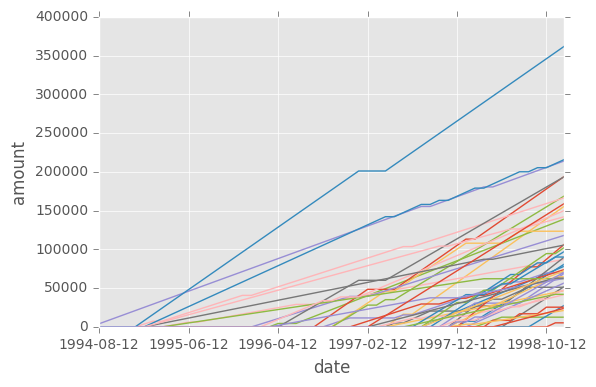

In [7]:
trans_plot = transaction_scope.cumsum()
plt.figure()
ax = trans_plot.plot(legend = False)
ax.set_ylabel("amount")

All these payments seem to have flat months indeed! As we assume that loans are payed monthly, the flat lines on the map appear to be missed payments. As order_info provides us with the heigth of every montly payment, we can plot the difference between the money ordered and eventually paid.  
Also, all payments occur on the 12th of the month. Many customers who sign the contract of the loan before the 12th, therefore providing a missing payment in the data which may be artificial. We assume that loan payments start the next month therefore we bump the date by 12 days if the day in the month is before the 12th, removing our missed payments.

In [8]:
from datetime import datetime
payment_diff = transaction_scope.copy()
for acct in scope:
    loan_start = loan_info[loan_info['account_id']==acct]['date'].unique()[0]
    loan_date = datetime.strptime(loan_start, '%Y-%m-%d')
    if loan_date.day < 12:
        loan_date = datetime(loan_date.year, loan_date.month, loan_date.day + 12)
    loan_start = loan_date.strftime('%Y-%m-%d')
    loan_order = loan_info[loan_info['account_id']==acct]['payments'].unique()[0]
    payment_diff.loc[payment_diff.index > loan_start, acct] = payment_diff.loc[payment_diff.index > loan_start,acct] - loan_order 

#### Plot all missed payments.

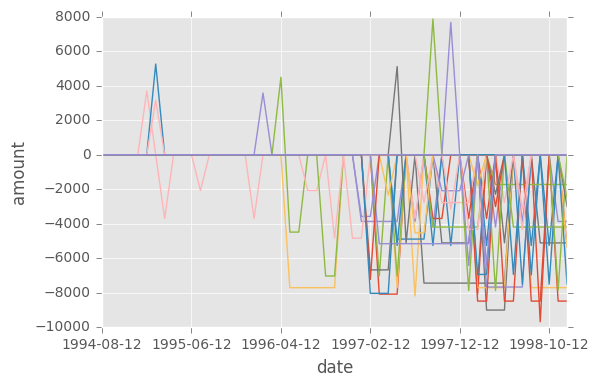

In [9]:
plt.figure()
ax = payment_diff.plot(legend = False)
ax.set_ylabel("amount")

On first inspection, it seems that we missed some initial payments. This is not a big deal as we are only intersted in missed payments and not so much in early payments (which may or may not have been refunded).  
Note also that in this graph, spikes are one-time missers, where plateaus are multiple consecutive missed payments.
Now, the main bulk of missed payments is at the end of the graph, this is because we look only at running loans, which are generally started later. 
Therefore we choose to revert this to once again looking at all loans and later look at only the running ones. This essentially means running the same code again, with the adjustment that for ended loans, we need to not assume that a zero payment after the startdate is a missed one.

In [10]:
scope = loan_info['account_id'].unique()
running = loan_info[loan_info['status']=='run_but_debt']['account_id'].unique()

transaction_scope = transaction_info[transaction_info['account_id'].isin(scope)]
transaction_scope = transaction_scope[transaction_scope['k_symbol']=='loan']

transaction_scope = transaction_scope.loc[:,['account_id','date','amount']]
transaction_scope = transaction_scope.pivot(index = 'date', 
                                            columns = 'account_id', 
                                            values = 'amount')
transaction_scope = transaction_scope.fillna(0)

We now have to add some months to have dates for every loan in the full dataset. Function borrowed from:
https://stackoverflow.com/questions/4130922/
Note that this code is somewhat messy but it will do for now.

In [11]:
from datetime import datetime
import calendar
def add_months(sourcedate, months):
    month = sourcedate.month - 1 + months
    year = int(sourcedate.year + month / 12 )
    month = month % 12 + 1
    day = min(sourcedate.day,calendar.monthrange(year,month)[1])
    return datetime(year,month,day)

payment_diff = transaction_scope.copy()
for acct in scope:
    if acct in running:
        loan_start = loan_info[loan_info['account_id']==acct]['date'].unique()[0]
        loan_date = datetime.strptime(loan_start, '%Y-%m-%d')
        if loan_date.day < 12:
            loan_date = datetime(loan_date.year, loan_date.month, loan_date.day + 12)
        loan_start = loan_date.strftime('%Y-%m-%d')
        loan_order = loan_info[loan_info['account_id']==acct]['payments'].unique()[0]
        payment_diff.loc[payment_diff.index > loan_start, acct] = payment_diff.loc[payment_diff.index > loan_start,acct] - loan_order 
    else:
        loan_start = loan_info[loan_info['account_id']==acct]['date'].unique()[0]
        loan_date = datetime.strptime(loan_start, '%Y-%m-%d')
        if loan_date.day < 12:
            loan_date = datetime(loan_date.year, loan_date.month, loan_date.day + 12)
        loan_start = loan_date.strftime('%Y-%m-%d')
        loan_date_end = add_months(loan_date,loan_info[loan_info['account_id']==acct]['duration'].unique()[0])
        loan_end = loan_date_end.strftime('%Y-%m-%d')
        monthly_payment = loan_info[loan_info['account_id']==acct]['payments'].unique()[0]
        dates = (payment_diff.index > loan_start) & (payment_diff.index < loan_end)
        payment_diff.loc[dates, acct] = payment_diff.loc[dates, acct] - monthly_payment


Now we can again make a plot. Which should show more earlier missed payments (and some more positives which were prepaid).

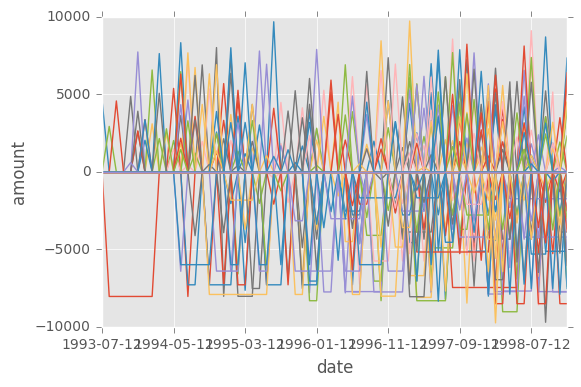

In [12]:
plt.figure()
ax = payment_diff.plot(legend = False)
ax.set_ylabel("amount")

### Missing payments into loan.
Now that we know this, we can do our final transformation on the missed payments. Even though we have information on the unemployment rates of '95 and '96, we act as if all our periods are equal. Hence we can now start making features.  
We will use the features:  
- Loan amount
- Loan duration
- Number of total missed payments
- Number of missed payments in first, second, third and last quarter of the loan
- Max number of consecutively missed payments

As we will provide the split into the 80/20 estimate, we will first split and then generate the features on the first 80%. The last 20% will only be provided a "missed payment" column which is either 0 or 1.

#### Let's first remake the above picture for 'months into loan'.
This means moving all starts to 0. My implementation seems suboptimal, but it will do the job. I could have also moved all transactions and redo the pivoting.

In [13]:
max_duration = loan_info['duration'].max()
monthly_missed = pd.DataFrame(index=range(0,60), columns=list(payment_diff))

In [14]:
for acct in scope:
    if acct in running:
        loan_start = loan_info[loan_info['account_id']==acct]['date'].unique()[0]
        tmp = payment_diff.loc[payment_diff.index > loan_start, acct].tolist()
        tmp = [round(i,0) for i in tmp]
        tmp = tmp + [0]*(60 - len(tmp))
        tmp = [int(i) for i in tmp]
        monthly_missed[acct] = tmp
    else:
        loan_start = loan_info[loan_info['account_id']==acct]['date'].unique()[0]
        loan_date = datetime.strptime(loan_start, '%Y-%m-%d')
        loan_date_end = add_months(loan_date,loan_info[loan_info['account_id']==acct]['duration'].unique()[0])
        loan_end = loan_date_end.strftime('%Y-%m-%d')
        tmp = payment_diff.loc[(payment_diff.index > loan_start) & (payment_diff.index < loan_end), acct].tolist()
        tmp = [round(i,0) for i in tmp]
        tmp = tmp + [0]*(60 - len(tmp))
        tmp = [int(i) for i in tmp]
        monthly_missed[acct] = tmp

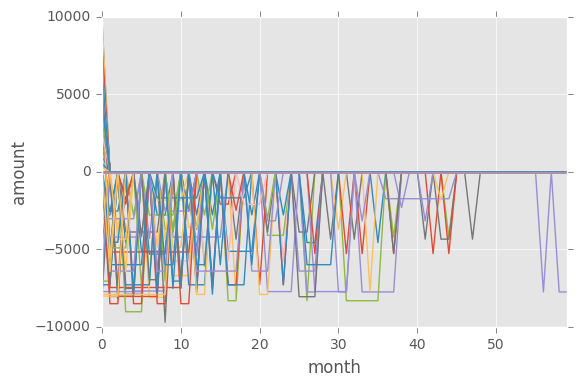

In [15]:
plt.figure()
ax = monthly_missed.plot(legend = False)
ax.set_ylabel("amount")
ax.set_xlabel("month")

This confirms the fact that payment differences which are positive occur in the first month. Hence, this is the prepayment mismatch we have (but at least we don't set ones to missed which aren't).

#### Let's make the loan table.

In [16]:
df = loan_info.copy()
df.columns = ['loan_id','account_id','start_date','amount','duration','payments','status']

#### Merge the total misses

In [17]:
tmp = pd.DataFrame(monthly_missed.apply(lambda column: (column < -1).sum()))
tmp.columns = ['total_missed']
df = pd.merge(left = df, right = tmp, left_on = 'account_id', right_index = True)

#### Split the dataset on loan duration

In [18]:
durations = df['duration'].value_counts().to_dict()
quarter_missed = {}
misses = pd.DataFrame(columns = ['first_quarter','second_quarter','third_quarter','last_quarter'])
for key in durations.keys():
    tmp =  df[df['duration']==int(key)]['account_id'].tolist()
    quarter_missed[key] = monthly_missed.loc[:,tmp]
    tmp_df = pd.DataFrame(quarter_missed[key].loc[range(0,key/4),].apply(lambda column: (column < -1).sum()))
    tmp_df['second_quarter'] = quarter_missed[key].loc[range(key/4, 2*key/4),].apply(lambda column: (column < -1).sum())
    tmp_df['third_quarter'] = quarter_missed[key].loc[range(2*key/4, 3*key/4),].apply(lambda column: (column < -1).sum())
    tmp_df['last_quarter'] = quarter_missed[key].loc[range(3*key/4, 4*key/4),].apply(lambda column: (column < -1).sum())
    tmp_df.columns = ['first_quarter','second_quarter','third_quarter','last_quarter']
    misses = pd.concat([misses,tmp_df])
for col in misses.columns:
    misses[col] = misses[col].astype(int)
df = pd.merge(left = df, right = misses, left_on = 'account_id', right_index = True)

In [19]:
quarter_missed.keys()

[48, 24, 60, 12, 36]

In [20]:
for col in misses.columns:
    misses[col] = misses[col].astype(int)

#### Max number of consecutively missed payments

In [21]:
consecutive = monthly_missed.copy()
consecutive[consecutive > -2] =0
consecutive[consecutive < -1] = -1

In [22]:
# From: https://stackoverflow.com/questions/36441521
import itertools
tmplist = []
for acct in consecutive.columns:
    a = consecutive[acct].tolist()
    z = [(x[0], len(list(x[1]))) for x in itertools.groupby(a)]
    z = [x for x in z if x[0] !=0]
    if len(z)==0:
        tmp = 0
    else:
        tmp = max(z, key=lambda x:x[1])[1]
    tmplist.append(tmp)
max_missed = pd.DataFrame()
max_missed['account_id'] = consecutive.columns
max_missed['max_missed'] = tmplist

In [23]:
df = pd.merge(left = df, right = max_missed, left_on = 'account_id', right_on = 'account_id')

## Client charasteristics
We look at the following charasteristics:
- Number of clients per account.
- Average balance on the account.
- Birthyear of the owner
- Sex of the owner
- Startyear of the account

Note that we will need to cut the data into 75% running time for finished clients when we accumulate different data.

#### Scope on only the clients with a loan:

In [24]:
client_scope = client_info[client_info['account_id'].isin(scope)]
client_scope.describe()


/Users/moeben001/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,client_id,district_id_client,disp_id,account_id,district_id_branch,loan_id,amount,duration,payments,card_id
count,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000,170.000000
mean,7171.419589,38.215236,7049.634825,5863.874244,37.621524,6180.746070,151801.538089,36.261185,4231.251511,791.076471
std,4053.288033,25.033481,3925.311133,3277.925506,25.195087,681.292733,114577.041848,17.172800,2238.757849,345.872296
min,2.000000,1.000000,2.000000,2.000000,1.000000,4959.000000,4980.000000,12.000000,304.000000,16.000000
25%,3608.500000,14.000000,3608.500000,2988.000000,13.000000,5585.000000,67536.000000,24.000000,2495.500000,NaN
50%,7011.000000,41.000000,7011.000000,5794.000000,39.000000,6190.000000,115992.000000,36.000000,3937.000000,NaN
75%,10795.500000,60.000000,10487.500000,8757.000000,60.000000,6760.500000,210564.000000,48.000000,5916.000000,NaN
max,13971.000000,77.000000,13663.000000,11362.000000,77.000000,7308.000000,590820.000000,60.000000,9910.000000,1247.000000


#### Get the number of clients

In [25]:
tmp = pd.DataFrame(client_scope.groupby('account_id').agg('count')['client_id'])
df = pd.merge(left = df, right = tmp, left_on = 'account_id', right_index = True)

#### Get the average balance on the account
For finished clients, cut all data after 75% of the running time. 
NB: This actually comes from the transaction_scope data.

In [27]:
# Get the scope
trans_scope = transaction_info[transaction_info['account_id'].isin(scope)]
trans_scope = pd.merge(left = trans_scope, right = df.loc[:,['account_id','start_date','duration','status']])
trans_scope['start_date'] = pd.to_datetime(trans_scope['start_date'], format='%Y-%m-%d')
trans_scope['date'] = pd.to_datetime(trans_scope['date'], format='%Y-%m-%d')
# Split the data in running and finished
trans_scope_running = trans_scope[trans_scope['status'].isin(['run_no_problem','run_but_debt'])].copy()
trans_scope_finished = trans_scope[trans_scope['status'].isin(['fin_no_problem','fin_unpaid'])].copy()
# Remove the transactions after the third quarter
trans_scope_finished['cutoff_duration'] = trans_scope_finished['duration']*3/4
trans_scope_finished['cutoff_date'] = trans_scope_finished['start_date'] + \
    trans_scope_finished['cutoff_duration'].values.astype("timedelta64[M]")
trans_scope_finished = trans_scope_finished[trans_scope_finished['cutoff_date'] > trans_scope_finished['date']]
# Remove the helpcolumns
del trans_scope_finished['cutoff_duration']
del trans_scope_finished['cutoff_date']

trans_scope = pd.concat([trans_scope_finished, trans_scope_running])

Calculate the average balance on the account.

In [ ]:
avg_balance = pd.DataFrame(trans_scope.groupby('account_id').agg('mean')['balance'])
df = pd.merge(left = df, right = avg_balance, left_on = 'account_id', right_index = True)

#### Get the average birthyear of the owner.

In [29]:
owner_scope = client_scope[client_scope['type_client']=="OWNER"].copy()
owner_scope['birth_number'] = pd.to_datetime(owner_scope['birth_number'], 
                                                format='%Y-%m-%d')
owner_scope['birthyear_owner'] = owner_scope['birth_number'].dt.year
df = pd.merge(left = df, 
              right = owner_scope.loc[:,['account_id','birthyear_owner']], 
              left_on = 'account_id', right_on = 'account_id')

#### Add the sex of the owner.

In [30]:
owner_scope['female'] = 0
owner_scope.loc[owner_scope.sex == 'F', 'female'] = 1
df = pd.merge(left = df, 
              right = owner_scope.loc[:,['account_id','female']], 
              left_on = 'account_id', right_on = 'account_id')

In [31]:
owner_scope['date_client'] = pd.to_datetime(owner_scope['date_client'], 
                                            format='%Y-%m-%d')
owner_scope['startyear_client'] = owner_scope['date_client'].dt.year
df = pd.merge(left = df, 
              right = owner_scope.loc[:,['account_id','startyear_client']], 
              left_on = 'account_id', right_on = 'account_id')

## Transactional behavior
Let's look at all the transactions
- The total number transactions
- The average volume per transaction
- The total number of cash transactions
- The aveage volume per cash transaction
- The total number of cc withdrawals
- The aveage volume per cc withdrawal

NB: We already filtered the finsihed contracts on the 75/25% split above.

In [32]:
trans_scope['operation'].value_counts()

cash_withdrawl    59801
outg_bank         34352
cash_credit       22952
inc_bank           6298
cc_withdrawal       639
Name: operation, dtype: int64

In [33]:
average_volume = pd.DataFrame(trans_scope.groupby('account_id').agg('mean')['amount'])
average_volume.columns = ['average_volume']
total_number = pd.DataFrame(trans_scope.groupby('account_id').agg(lambda x: len(x.unique()))['trans_id'])
total_number.columns = ['total_number_trans']

In [34]:
total_number_cash = pd.DataFrame(trans_scope[trans_scope['operation'].isin(['cash_credit','cash_withdrawl'])].groupby('account_id').agg(lambda x: len(x.unique()))['trans_id'])
total_number_cash.columns = ['total_number_cash']
average_cash_volume = pd.DataFrame(trans_scope[trans_scope['operation'].isin(['cash_credit','cash_withdrawl'])].groupby('account_id').agg('mean')['amount'])
average_cash_volume.columns = ['average_volume_cash']

In [35]:
total_number_cc = pd.DataFrame(trans_scope[trans_scope['operation']=="cc_withdrawal"].groupby('account_id').agg(lambda x: len(x.unique()))['trans_id'])
total_number_cc.columns = ['total_number_cc']
average_cc_volume = pd.DataFrame(trans_scope[trans_scope['operation']=="cc_withdrawal"].groupby('account_id').agg('mean')['amount'])
average_cc_volume.columns = ['average_volume_cc']

In [36]:
df = pd.merge(left = df, right = average_volume, 
              left_on = 'account_id', right_index = True, 
              how ='left')
df = pd.merge(left = df, right = total_number, 
              left_on = 'account_id', right_index = True, 
              how ='left')
df = pd.merge(left = df, right = total_number_cash, 
              left_on = 'account_id', right_index = True, 
              how ='left')
df = pd.merge(left = df, right = average_cash_volume, 
              left_on = 'account_id', right_index = True, 
              how ='left')
df = pd.merge(left = df, right = total_number_cc, 
              left_on = 'account_id', right_index = True, 
              how ='left')
df = pd.merge(left = df, right = average_cc_volume, 
              left_on = 'account_id', right_index = True, 
              how ='left')

In [37]:
df = df.fillna(0)

## Demographic information
Not taking everything in acocunt (as not account/client specific information).
We will use: 
- inhabitants
- urban_ratio
- avg unemployment rate (1995 & 1996) divided by # of inhabitants
- avg commited crimes (1995 & 1996)

In [38]:
demographic_info['avg_unemployment'] = demographic_info[['unemployment_rate_1995', 'unemployment_rate_1996']].mean(axis=1)
demographic_info['avg_committed_crimes'] = demographic_info[['committed_crimes_1995', 'comitted_crimes_1996']].mean(axis=1)
demographic_info.loc[:,'avg_committed_crimes'] = demographic_info.loc[:,'avg_committed_crimes']/demographic_info.loc[:,'inhabitants']

In [39]:
df = pd.merge(left = df,
           right = owner_scope.loc[:,['account_id','district_id_client']],
           how = 'left',
           left_on = 'account_id',
           right_on = 'account_id')

In [40]:
df = pd.merge(left = df,
           right = demographic_info.loc[:,['district_id','inhabitants','urban_ratio',
                                           'avg_unemployment','avg_committed_crimes']],
           how = 'left',
           left_on = 'district_id_client',
           right_on = 'district_id')

## Card info
- We will only look at the type of card
We will try to make two groups. We have no information on what 'junior', 'classic' or gold is. Thus we will make a plot to see whether they have any influence on the loan status.  
We only have 107 credit cards for all customers having a loan. Only 5 of those have no debt.
Thus we deicd to drop card info for now.

In [41]:
card_scope = client_info.loc[:,['status','type_card']].dropna()
card_scope['status'].value_counts()

run_no_problem    105
fin_no_problem     60
run_but_debt        3
fin_unpaid          2
Name: status, dtype: int64

#### Save the data frame:

In [42]:
df.to_csv('data/loan_prep.csv', index = False)